## Problem 2: Interpolation between images using GAN (24 points)
    
Trained GANs can generate images from a simple random distribution (e.g., Gaussian or uniform).
We can in principle “animate” the transition of one image into another by interpolating between
them using linear interpolation in the space of the simple random distribution, rather than image
space.

    a) Train a GAN on MNIST using class code as starting point.

### Initialize

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

slim = tf.contrib.slim

C:\Users\Zenaardvark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# Use if running on a GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

### Load Data

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Utility Functions

In [6]:
def variables_from_scope(scope_name):
    """
    Returns a list of all trainable variables in a given scope. This is useful when
    you'd like to back-propagate only to weights in one part of the network
    (in our case, the generator or the discriminator).
    """
    return tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope_name)

def visualize_row(images, img_dim=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a row
    in a plot, using `cmap` to map from numbers to colors.
    """
    im = np.concatenate(np.reshape(images, [-1,img_dim,img_dim]), 1)
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()   

### Hyperparameters

In [7]:
# Graph parameters
z_dimension = 32
intermediate_layer_size = 128
image_size = 784

# Training parameters
batch_size = 50
iterations = 25000

### Generator/Discriminator

In [9]:
# Generator
def generator(z):
    hidden_layer = tf.layers.dense(z, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

# Discriminator
def discriminator(images):
    hidden_layer = tf.layers.dense(images, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

### Graph

In [10]:
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
z = tf.placeholder(tf.float32, [None, z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator(z)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator(fake_X)
    scope.reuse_variables()
    d_on_real = discriminator(real_X)

# Loss
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

# Initializer
initialize_all = tf.global_variables_initializer()

### Training

In [12]:
# Feed Functions
def make_noise():
    return np.random.uniform(-1.0, 1.0, [batch_size, z_dimension])

def next_feed_dict():
    return {real_X: mnist.train.next_batch(batch_size)[0],
            z:      make_noise()}

Iter [       0] Time [0.7581] d_loss [1.3669]


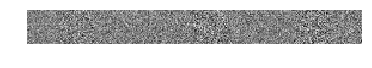

Iter [    1000] Time [3.3980] d_loss [0.0043]


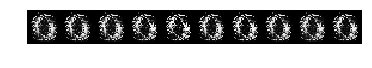

Iter [    2000] Time [6.1570] d_loss [0.0742]


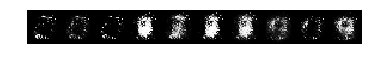

Iter [    3000] Time [8.8202] d_loss [0.1609]


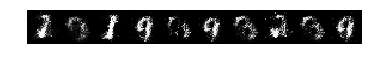

Iter [    4000] Time [11.4774] d_loss [0.3504]


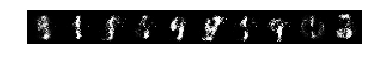

Iter [    5000] Time [14.1550] d_loss [0.0753]


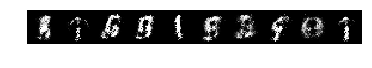

Iter [    6000] Time [16.7830] d_loss [0.1621]


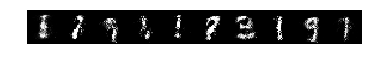

Iter [    7000] Time [19.4728] d_loss [0.5656]


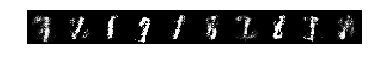

Iter [    8000] Time [22.2238] d_loss [0.6231]


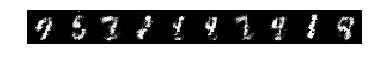

Iter [    9000] Time [24.9014] d_loss [0.4872]


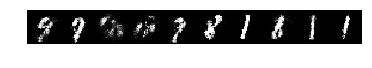

Iter [   10000] Time [27.6036] d_loss [0.4780]


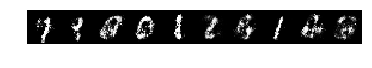

Iter [   11000] Time [30.2459] d_loss [0.7081]


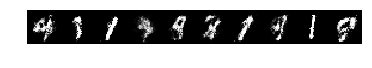

Iter [   12000] Time [32.7983] d_loss [0.4096]


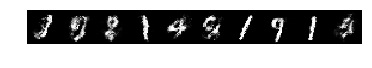

Iter [   13000] Time [35.5325] d_loss [0.3641]


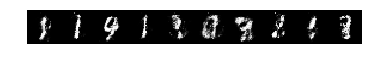

Iter [   14000] Time [38.4466] d_loss [0.6095]


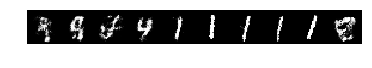

Iter [   15000] Time [41.1194] d_loss [0.7265]


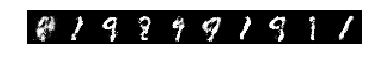

Iter [   16000] Time [43.9263] d_loss [0.7584]


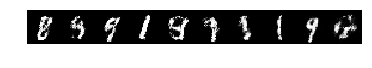

Iter [   17000] Time [46.9837] d_loss [0.5704]


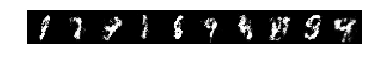

Iter [   18000] Time [49.6865] d_loss [0.5631]


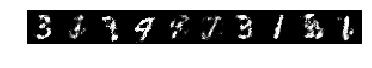

Iter [   19000] Time [52.3232] d_loss [0.6017]


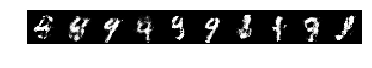

Iter [   20000] Time [54.9743] d_loss [0.5891]


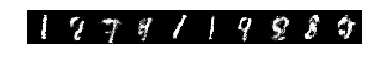

Iter [   21000] Time [57.6147] d_loss [0.5897]


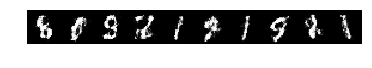

Iter [   22000] Time [60.2360] d_loss [0.8457]


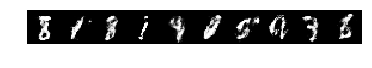

Iter [   23000] Time [62.8903] d_loss [0.5739]


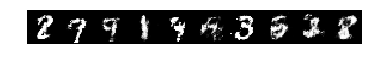

Iter [   24000] Time [65.5506] d_loss [0.7533]


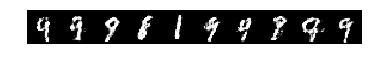

Iter [   24999] Time [68.2134] d_loss [0.6063]


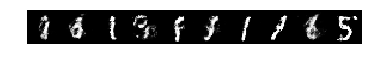

In [11]:
# Train the GAN.
sess = tf.Session()
sess.run(initialize_all)

start_time = time.time()
for t in range(iterations):
    sess.run(g_step, feed_dict=next_feed_dict())
    _, loss = sess.run([d_step, d_loss], feed_dict=next_feed_dict())

    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict={z: make_noise()})
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

    b) Generate some images, say 10, by first drawing samples, e, from the simple distribution
    and then feeding them through the generator.

In [17]:
#e_noise is a random distribution set of 10
e_noise = np.random.uniform(-1.0, 1.0, [10, z_dimension])

#we collect our fake data from that set
fake_data = sess.run(fake_X, feed_dict={z: e_noise})

    c) Visualize the images and pick any two (preferably different digit labels), identify their
    inputs and set them to e_start and e_end.

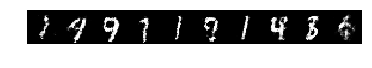

In [18]:
#Just for visualization
visualize_row(fake_data)

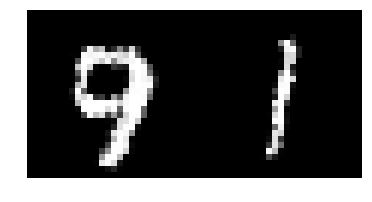

In [20]:
#We will select 2 and 4 as they look the most different
e_start = e_noise[2]
e_end = e_noise[4]

#Let's check that it works
fake_data = sess.run(fake_X, feed_dict={z: [e_start,e_end]})
visualize_row(fake_data)

    d) Generate 10 steps between e_start and e_end by linear interpolation.

In [22]:
#Create a matrix to slot in our interpolation
e_interpolate = np.zeros((10, z_dimension))

#Interpolate for each value
for i in range(z_dimension):
    e_interpolate[:,i] = np.linspace(e_start[i] ,e_end[i] , num=10)

    e) Generate 10 images using e_start = e_1, e_2, ..., e_10 = e_end as inputs to the generator and
    visualize them

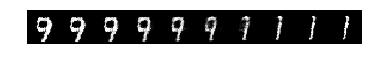

In [24]:
#Let's plug our interpolated data back in
fake_data = sess.run(fake_X, feed_dict={z: e_interpolate})
visualize_row(fake_data)

## Problem 3. Interpolating with variational autoencoders (24 points)

We can similarly interpolate between images using Variational Autoencoders (VAE).

    a) Train a variational autoencoder on MNIST using class code as starting point.

### Encoder/Decoder

In [44]:
def encoder(x):
    """Network q(z|x)"""
    with slim.arg_scope([slim.fully_connected],
                    activation_fn=tf.nn.relu,
                    weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):
        mu_logvar = slim.fully_connected(x, 128, scope='fc1')
        mu_logvar = slim.fully_connected(mu_logvar, 128, activation_fn=None, scope='fc2')
        
    return mu_logvar

def decoder(mu_logvar):
    """Network p(x|z)"""
    # Interpret z as concatenation of mean and log variance
    mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)

    # Standard deviation must be positive
    stddev = tf.sqrt(tf.exp(logvar))

    # Draw a z from the distribution
    epsilon = tf.random_normal(tf.shape(stddev))
    z = mu + tf.multiply(stddev, epsilon)

    # Decoding arm
    with slim.arg_scope([slim.fully_connected],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(0.0, 0.1)):        
        x_logits = slim.fully_connected(z, 128, scope='fc1')
        x_logits = slim.fully_connected(x_logits, 784, activation_fn=None, scope='fc2')
        
        # x_hat to be generated from a Bernoulli distribution
        x_dist = tf.contrib.distributions.Bernoulli(logits=x_logits, dtype=tf.float32)
        
    return x_logits, x_dist

### Loss

In [45]:
def optimizer(x_logits, x, mu_logvar):
    """Define loss functions (reconstruction, KL divergence) and optimizer"""
    with tf.variable_scope('optimizer') as scope:            
        # Reconstruction loss
        reconstruction = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_logits), reduction_indices=[1])
 
        # KL divergence
        mu, logvar = tf.split(mu_logvar, num_or_size_splits=2, axis=1)
        kl_d = -0.5 * tf.reduce_sum(1.0 + logvar - tf.square(mu) - tf.exp(logvar), reduction_indices=[1])
        
        # Total loss
        loss = tf.reduce_mean(reconstruction + kl_d)
            
        # ADAM optimizer
        train_step = tf.train.AdamOptimizer().minimize(loss)
    
    return train_step

### Visual Reconstruction (VA)

In [46]:
def visualize_row_va(image, reconstruction, img_width=28, cmap='gray'):
    """
    Takes in a tensor of images of given width, and displays them in a column
    in a plot, using `cmap` to map from numbers to colors.
    """
    fig, ax = plt.subplots(1, 2)
    image = np.reshape(image, [-1, img_width])
    reconstruction = np.reshape(reconstruction, [-1, img_width])
    plt.figure()
    ax[0].imshow(np.clip(image, 0, 1), cmap=cmap)
    ax[1].imshow(np.clip(reconstruction, 0, 1), cmap=cmap)
    plt.show()

### Graph

In [47]:
# Reset the graph
tf.reset_default_graph()

# Define input placeholder
x = tf.placeholder(tf.float32,[None, 784], name='x')

# Define VAE graph
with tf.variable_scope('encoder'):
    mu_logvar = encoder(x)
with tf.variable_scope('decoder'):
    x_logits, x_dist = decoder(mu_logvar)
    x_hat = x_dist.sample()

# Optimization
with tf.variable_scope('unlabeled') as scope:
    train_step_unlabeled = optimizer(x_logits, x, mu_logvar)

### Training

Iteration 0:


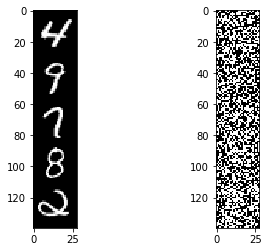

<Figure size 432x288 with 0 Axes>

Iteration 1000:


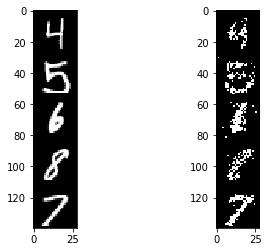

<Figure size 432x288 with 0 Axes>

Iteration 2000:


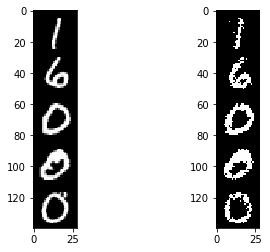

<Figure size 432x288 with 0 Axes>

Iteration 3000:


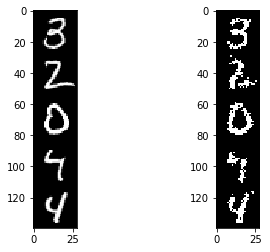

<Figure size 432x288 with 0 Axes>

Iteration 4000:


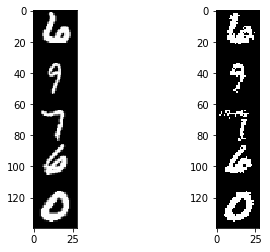

<Figure size 432x288 with 0 Axes>

Iteration 5000:


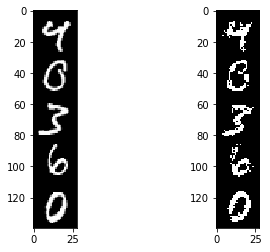

<Figure size 432x288 with 0 Axes>

Iteration 6000:


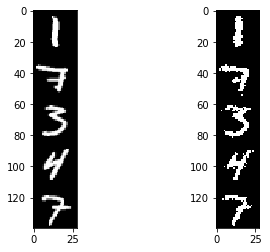

<Figure size 432x288 with 0 Axes>

Iteration 7000:


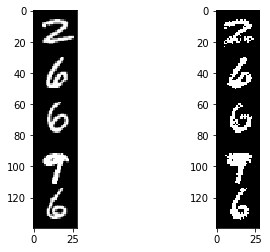

<Figure size 432x288 with 0 Axes>

Iteration 8000:


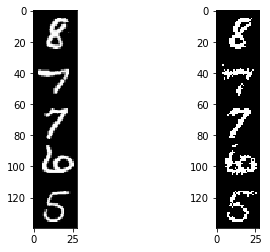

<Figure size 432x288 with 0 Axes>

Iteration 9000:


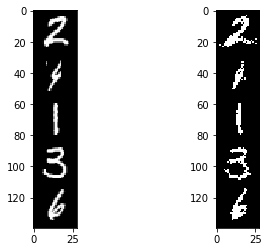

<Figure size 432x288 with 0 Axes>

Iteration 10000:


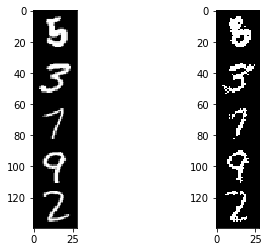

<Figure size 432x288 with 0 Axes>

Iteration 11000:


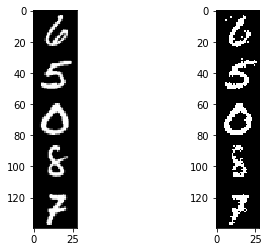

<Figure size 432x288 with 0 Axes>

Iteration 12000:


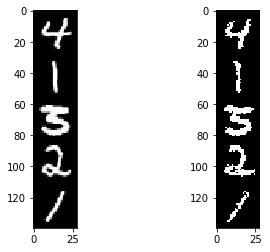

<Figure size 432x288 with 0 Axes>

Iteration 13000:


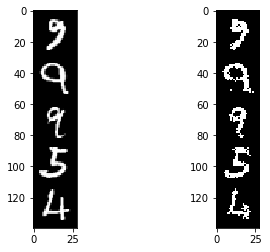

<Figure size 432x288 with 0 Axes>

Iteration 14000:


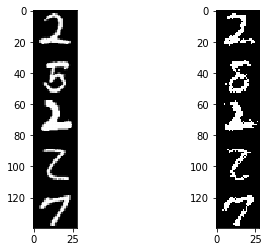

<Figure size 432x288 with 0 Axes>

Iteration 15000:


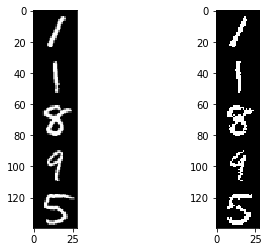

<Figure size 432x288 with 0 Axes>

Iteration 16000:


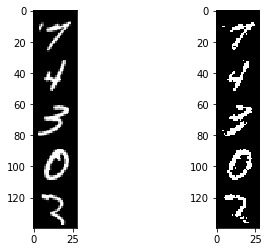

<Figure size 432x288 with 0 Axes>

Iteration 17000:


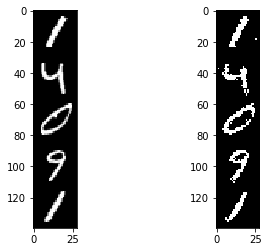

<Figure size 432x288 with 0 Axes>

Iteration 18000:


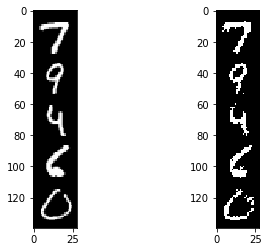

<Figure size 432x288 with 0 Axes>

Iteration 19000:


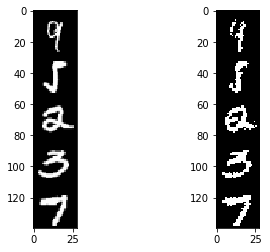

<Figure size 432x288 with 0 Axes>

In [54]:
# Initialize all variables
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train VAE model
for i in range(20000):        
    # Get a training minibatch
    batch = mnist.train.next_batch(100)

    # Binarize the data
    x_binarized = (batch[0] > 0.5).astype(np.float32)

    # Train on minibatch
    sess.run(train_step_unlabeled, feed_dict={x: x_binarized}) # No labels

    # Visualize reconstructions every 1000 iterations
    if i % 1000 == 0:
        batch = mnist.validation.next_batch(5)
        x_binarized = (batch[0] > 0.5).astype(np.float32)
        reconstructions = sess.run(x_hat, feed_dict={x: x_binarized})
        print("Iteration {0}:".format(i))
        visualize_row_va(batch[0], reconstructions)

    b) Using the encoder, generate latent representations for 2 images (z_start and z_end)
    matching the digit labels selected in Problem 2c.

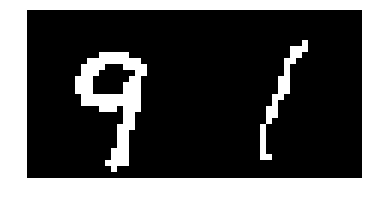

In [79]:
start_cond = False
end_cond = False

#Lets select two data items of labels 9 and 1
while start_cond == False or end_cond == False:  
    curr_selection = mnist.train.next_batch(1)
    if curr_selection[1][0][9] == 1:
        z_start = (curr_selection[0] > 0.5).astype(np.float32)
        start_cond = True
    if curr_selection[1][0][1] == 1:
        z_end = (curr_selection[0] > 0.5).astype(np.float32)
        end_cond = True

#Visualize to show what we picked
visualize_row([z_start,z_end])

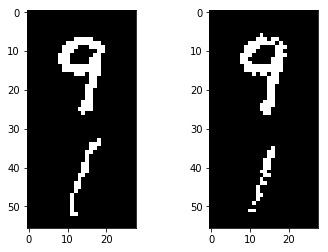

<Figure size 432x288 with 0 Axes>

In [82]:
#Let's grab our latent representations from the encoder
x_input = np.reshape([z_start,z_end],[2,784])
latent_representations = sess.run(mu_logvar, feed_dict={x: x_input})

#And visualize just those two when passed through the 
reconstructions = sess.run(x_hat, feed_dict={mu_logvar: latent_representations})
visualize_row_va(x_input, reconstructions)

    c) Generate (via decoding) and visualize images from 10 steps z_start = z_1, z_2, ..., z_10 = z_end
    using linear interpolation.

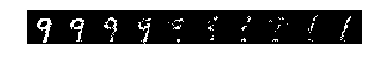

In [91]:
#Create a matrix to slot in our interpolation
z_interpolate = np.zeros((10, 128))

#Interpolate for each value
for i in range(128):
    z_interpolate[:,i] = np.linspace(latent_representations[0,i] ,latent_representations[1,i] , num=10)

#Visualization
reconstructions = sess.run(x_hat, feed_dict={mu_logvar: z_interpolate})
visualize_row(reconstructions)

    d) How does the quality of the VAE generated images compare to those from GAN?

I'd say generally the quality is better for the VAE in terms of pure readability.  The digits are very sharp as shown in the training outputs for the VAE.  The GAN outputs can be rather indescriminate in terms of class.

    e) Do you observe any differences in the smoothness of the interpolation from both models?

The interpolation for the GAN shows the digits remaining as nines up until the middle point where they switch over to ones.  The VAE has a smoother transition showing a bunch of proto-digits which don't read as anything in particular that could be contrived as being between 9 and 1.  This is likely due to the reliance on the input decoding.  

## Problem 4: Conditioning on class labels (24 points)
    
Trained GANs can generate images from simple distributions, however, we have almost no
control over the generated images. Assuming we want to generate images from specific digits,
we can modify GAN to generate images conditioned on the digit label, i.e., a conditional GAN.

    a) Modify the code from Problem 2 to take as input a vector 10 times larger.

In [8]:
#We want to add the onehot vector encoding to both the generator and the discriminator

# Generator
def generator_with_label(z, label):
    
    z_with_label = tf.concat([z,label],1)
    
    hidden_layer = tf.layers.dense(z_with_label, intermediate_layer_size, name="G1", activation=tf.nn.relu)
    fake_X = tf.layers.dense(hidden_layer, image_size, name="G2", activation=tf.sigmoid)
    return fake_X

# Discriminator
def discriminator_with_label(images, label):
    
    images_with_label = tf.concat([images,label],1)
    
    hidden_layer = tf.layers.dense(images_with_label, intermediate_layer_size, name="D1", activation=tf.nn.relu)
    D_output = tf.layers.dense(hidden_layer, 1, name="D2", activation=tf.sigmoid)
    return D_output

    b) Modify the code from Problem 2 to take as input the concatenation of e (random vector)
    and a one-hot vector encoding of the labels.

In [9]:
def with_label():
    curr_batch = mnist.train.next_batch(batch_size)
    return {real_X: curr_batch[0],
            label:  curr_batch[1],
            z:      make_noise()}

    c) Train the GAN.

In [10]:
#Let's up the iteration count a little bit
iterations = 30000

Iter [       0] Time [0.6391] d_loss [1.3440]


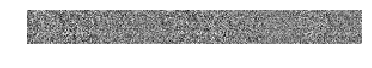

Iter [    1000] Time [3.5158] d_loss [0.0248]


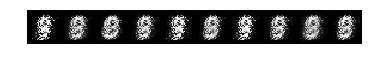

Iter [    2000] Time [6.4276] d_loss [0.0177]


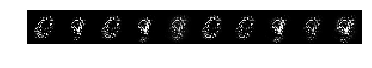

Iter [    3000] Time [9.2989] d_loss [0.1171]


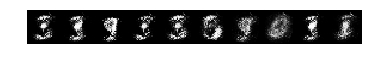

Iter [    4000] Time [12.1841] d_loss [0.1359]


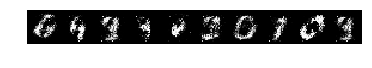

Iter [    5000] Time [15.0664] d_loss [0.1526]


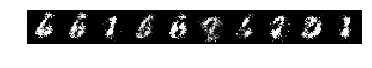

Iter [    6000] Time [17.8533] d_loss [0.3269]


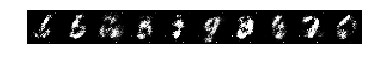

Iter [    7000] Time [20.7115] d_loss [0.1763]


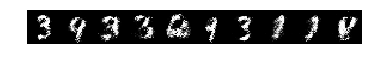

Iter [    8000] Time [23.5984] d_loss [0.2406]


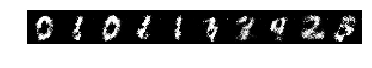

Iter [    9000] Time [26.5168] d_loss [0.5771]


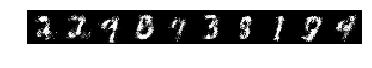

Iter [   10000] Time [29.4216] d_loss [0.6708]


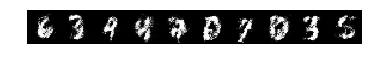

Iter [   11000] Time [32.3592] d_loss [0.4439]


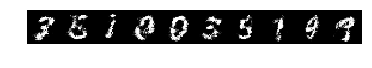

Iter [   12000] Time [35.1944] d_loss [0.5074]


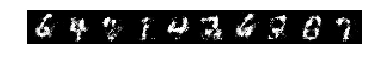

Iter [   13000] Time [38.1209] d_loss [0.7633]


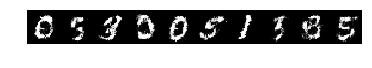

Iter [   14000] Time [41.0177] d_loss [0.8585]


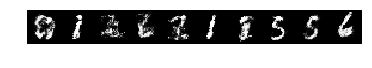

Iter [   15000] Time [43.9005] d_loss [0.9160]


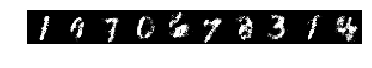

Iter [   16000] Time [46.8412] d_loss [0.8896]


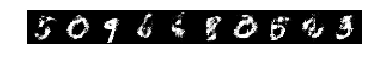

Iter [   17000] Time [49.6123] d_loss [0.9422]


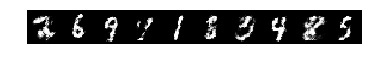

Iter [   18000] Time [52.5314] d_loss [1.1275]


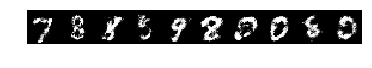

Iter [   19000] Time [55.4131] d_loss [0.7797]


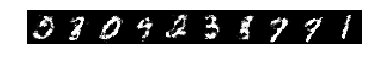

Iter [   20000] Time [58.2512] d_loss [1.0357]


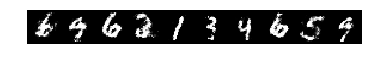

Iter [   21000] Time [61.1653] d_loss [0.8140]


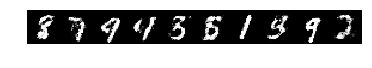

Iter [   22000] Time [64.0537] d_loss [0.8664]


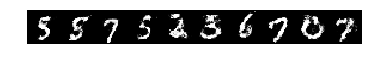

Iter [   23000] Time [66.8215] d_loss [0.6305]


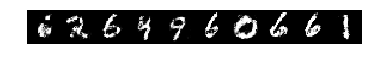

Iter [   24000] Time [69.6851] d_loss [0.8586]


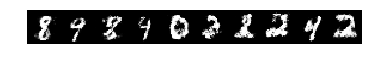

Iter [   25000] Time [72.5618] d_loss [0.8750]


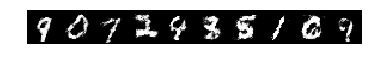

Iter [   26000] Time [75.4353] d_loss [1.0356]


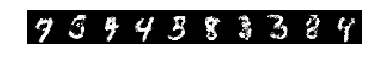

Iter [   27000] Time [78.3565] d_loss [0.9955]


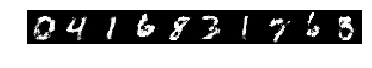

Iter [   28000] Time [81.1082] d_loss [0.6961]


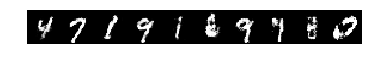

Iter [   29000] Time [83.9518] d_loss [0.8955]


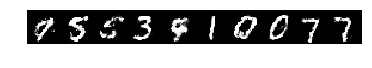

Iter [   29999] Time [86.8071] d_loss [0.9434]


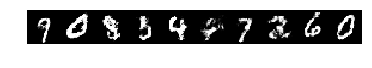

In [13]:
# Reset the graph
tf.reset_default_graph()

# Placeholders
real_X = tf.placeholder(tf.float32, [None, image_size])
label = tf.placeholder(tf.float32, [None, 10])
z = tf.placeholder(tf.float32, [None, z_dimension])

# Generator
with tf.variable_scope("generator") as scope:
    fake_X = generator_with_label(z,label)

# Discriminator
with tf.variable_scope("discriminator") as scope:
    d_on_fake = discriminator_with_label(fake_X,label)
    scope.reuse_variables()
    d_on_real = discriminator_with_label(real_X,label)

# Loss
g_loss = -tf.reduce_mean(tf.log(d_on_fake))
d_loss = -tf.reduce_mean(tf.log(d_on_real) + tf.log(1. - d_on_fake))

# Optimizer
optimizer = tf.train.AdamOptimizer()
d_step = optimizer.minimize(d_loss, var_list=variables_from_scope("discriminator"))
g_step = optimizer.minimize(g_loss, var_list=variables_from_scope("generator"))

#Run the training
sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = time.time()
for t in range(iterations):
    sess.run(g_step, feed_dict=with_label())
    #sess.run(r_step, feed_dict=put_in)
    _, loss = sess.run([d_step, d_loss], feed_dict=with_label())

    if t % 1000 == 0 or t+1 == iterations:
        fake_data = sess.run(fake_X, feed_dict=with_label())
        print('Iter [%8d] Time [%5.4f] d_loss [%.4f]' % (t, time.time() - start_time, loss))
        visualize_row(fake_data[:10])

    d) Generate and visualize 10 images from each digit by setting the labels accordingly as
    inputs to the generator and e at random from its distribution.

10 images for Label 0:


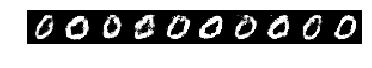

10 images for Label 1:


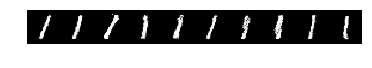

10 images for Label 2:


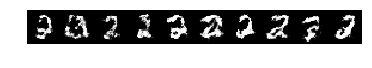

10 images for Label 3:


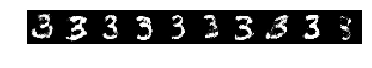

10 images for Label 4:


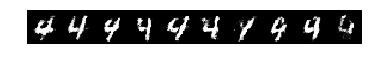

10 images for Label 5:


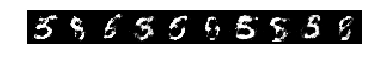

10 images for Label 6:


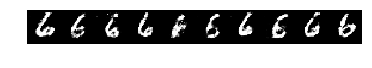

10 images for Label 7:


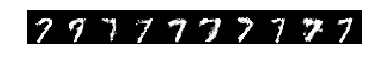

10 images for Label 8:


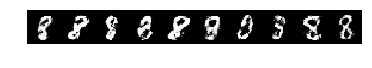

10 images for Label 9:


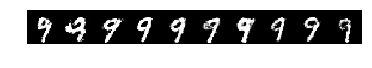

In [17]:
for i in range(10):
    
    one_hot = np.zeros((10,10))
    one_hot[:,i] = 1
    noise = np.random.uniform(-1.0, 1.0, [10, z_dimension])
    
    fake_data = sess.run(fake_X, feed_dict={z: noise, label: one_hot})
    print('10 images for Label %d:' % (i))
    visualize_row(fake_data)